# Assignment 9 (Bài về nhà): Word embeddings cho bài toán hệ gợi ý
Tổng quan: ở bài tập này chúng ta áp dụng word2vec cho bài toán hệ gợi ý. Sử dụng dữ liệu về lịch sử mua bánbán Online Retail Dataset (Online Retail.xlsx)

## Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

## Câu hỏi 1: khảo sát dữ liệu, xem dữ liệu có bao nhiêu bản ghi, bao nhiêu thuộc tính, xem dữ liệu của 5 bản ghi đầu tiên.


In [2]:
df = pd.read_excel('/content/Online Retail.xlsx')

In [3]:
#### YOUR CODE HERE ####

df.head(5)

#### END YOUR CODE #####

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Xử lý dữ liệu với các giá trị missing

In [4]:
# Kiểm tra các giá trị còn thiếu
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


<br>
Loại bỏ tất cả các hàng dữ liệu bị missing values.

In [5]:
# loại bỏ các giá trị missing
df.dropna(inplace=True)

# Một lần nữa kiểm tra các missing values
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


## Chuẩn bị dữ liệu

Chuyển StockCode thành kiểu dữ liệu string

In [6]:
df['StockCode']= df['StockCode'].astype(str)

Kiểm tra số lượng khách hàng trong tập dataset

In [7]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

Có tổng cộng 4,372 khác hàng trong bộ dataset. Với mỗi khách hàng chúng ta sẽ trích xuất lịch sử mua bán của họ. Hay nói cách khác chúng ta sẽ có 4,372 chuỗi mua hàng.

Với tập dữ liệu đầu vào, chúng ta sử dụng dữ liệu của 90% khách hàng để tạo word2vec embeddings, số còn lại ta dùng để đánh giá. Vì vậy ta chia tập dữ liệu như sau:

In [8]:
# trộn ID của khách hàng
random.shuffle(customers)

# Lấy 90% ID của khác hàng
# Chia tập dữ liệu thành bộ train và validation
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]
customers_validation = [customers[i] for i in range(len(customers)) if customers[i] not in customers_train]

In [10]:
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[df['CustomerID'].isin(customers_validation)]

In [11]:
print(len(train_df))
print(len(validation_df))

363249
43580


Tạo chuỗi mua hàng của các khách hàng trong hai tập train và validation

In [12]:
purchases_train = []

# điền mã sản phẩm vào danh sách tập train
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:03<00:00, 1106.66it/s]


In [13]:
purchases_val = []

# điền mã sản phẩm vào danh sách tập validation
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 437/437 [00:00<00:00, 1640.98it/s]


## Câu hỏi 2: Xây dựng mô hình biểu diễn cho các sản phẩm trong bộ dữ liệu train:
- Xây dựng mô hình, sử dụng Word2Vec(), với các tham số: window = 10, sg = 1, hs = 0, negative = 10, alpha=0.03, min_alpha=0.0007, seed = 14
- Xây dựng vocab cho mô hình, sử dụng build_vocab() cho model với bộ dữ liệu train và tham số progress_per=200
- Training cho model, sử dụng train() trên tập dữ liệu train, với các tham số total_examples = model.corpus_count, epochs=10, report_delay=1


In [14]:
model = Word2Vec(sg=1, hs=0, negative=10, alpha=0.03, min_alpha=0.0007, seed=14)

In [15]:
# lưu word2vec model
model.save("word2vec.model")
model.build_vocab(purchases_train, progress_per=200)
model.train(purchases_train, total_examples=model.corpus_count, epochs=10, report_delay=1)



(3595786, 3632490)

Vì chúng ta không train mô hình thêm nữa, nên chúng ta gọi init_sims(), để giúp mô hình thêm hiệu quả về bộ nhớ.

In [16]:
model.init_sims(replace=True)

In [17]:
print(model)

Word2Vec<vocab=3170, vector_size=100, alpha=0.03>


Bây giờ ta sẽ trích xuất vector của tất cả các từ trong vocab, và lưu chúng lại một nơi để dễ dàng truy cập.

In [19]:
# X = model[model.wv.vocab]
X = model.wv[list(model.wv.key_to_index.keys())]
X.shape

(3170, 100)

##  Visualize word2vec Embeddings

Visualize kết quả word2vec sử dụng thuật toán UMAP. Ở đây, vì mỗi vector có số chiều là 100, nên ta chuyển chúng về 2 chiều để hiển thị.


In [24]:
!pip uninstall umap
!pip install umap-learn

Found existing installation: umap 0.1.1
Uninstalling umap-0.1.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/umap-0.1.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/umap/*
Proceed (Y/n)? Y
  Successfully uninstalled umap-0.1.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.2 MB/s eta 0:00:00


In [25]:
import umap.umap_ as umap
reducer = umap.UMAP()

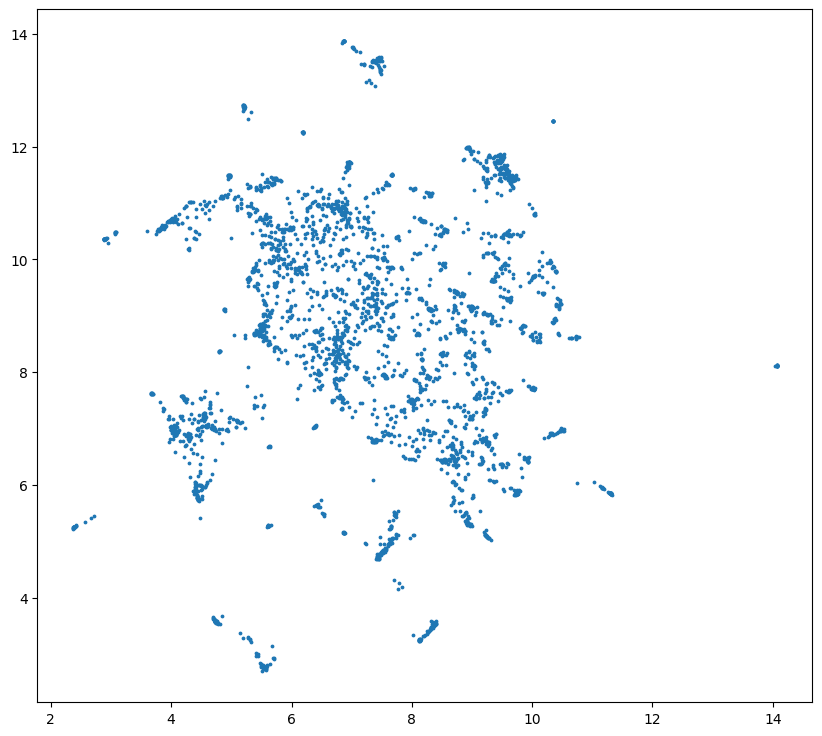

In [26]:

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

Mỗi một điểm trong hình là của một sản phẩm. Chúng ta có thể thấy rằng, có nhiều cụm của các sản phẩm giống nhau.

## Bắt đầu gợi ý các sản phẩm

Đến đây, chúng ta đã có word2vec embeddings cho từng sản phẩm trong bộ dữ liệu Online Retail. Bước tiếp theo, ta sẽ gợi ý các sản phẩm tương tự cho một sản phẩm.

Đầu tiên, tạo một từ điển về ID và mô tả của phẩm để dễ dàng map một mô tả sản phẩm với ID của nó và ngược lại.

In [27]:
products = train_df[["StockCode", "Description"]]

# Loại bỏ sự trùng lặp
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# Tạo từ điển
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()


In [28]:
# Kiểm tra từ điển
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

## Câu hỏi 3: Xây dựng hàm tính similarity của sản phẩm

Hàm nhận vào là vector của một sản phẩm cần gợi ý, đầu ra là 6 sản phẩm tương tự mà hệ thống sẽ gợi ý


In [31]:
def similar_products(v, n = 6):

    # Trích xuất ra những sản phẩm tương tự với sản phẩm đầu vào nhất
    ms = model.wv.similar_by_vector(v, topn= n+1)[1:]
    # Trích xuất ra tên và độ tương tự của các sản phẩm ở trên (trong ms),
    # và trả về giá trị cho hàm
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
    return new_ms


Thử hàm trên với một sản phẩm: '90019A' ('SILVER M.O.P ORBIT BRACELET')

In [33]:
similar_products(model.wv['90019A'])

[('GREEN HEART OF GLASS BRACELET', 0.8149154186248779),
 ('BLUE MURANO TWIST BRACELET', 0.7951106429100037),
 ('SILVER LARIAT BLACK STONE EARRINGS', 0.7863330841064453),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.7817334532737732),
 ('PINK HEART OF GLASS BRACELET', 0.778854250907898),
 ('GREEN MURANO TWIST BRACELET', 0.7728294730186462)]